In [266]:
!pip install -q pandas numpy openpyxl statsmodels matplotlib seaborn


[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [125]:
import os

os.makedirs("dataset", exist_ok=True)

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



pd.set_option('display.float_format', lambda x: '%.4f' % x)

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.titlepad'] = 20

# ind_code_s에서 7분
# ind_code_d에서 74분
ind_code_class = "ind_code_s"

In [127]:
ff49 = pd.read_excel("./rawdata/FF49industries.xlsx")

In [128]:
ff49

,코드,한국분류,FF
0,11,작물 재배업,1_Agric
1,31,어로 어업,1_Agric
2,62,비철금속 광업,17_BldMt
3,101,"도축, 육류 가공 및 저장 처리업",2_Food
4,102,수산물 가공 및 저장 처리업,2_Food
...,...,...,...
156,857,교육 지원 서비스업,33_PerSv
157,901,창작 및 예술관련 서비스업,7_Fun
158,911,스포츠 서비스업,7_Fun
159,912,유원지 및 기타 오락관련 서비스업,7_Fun


In [129]:
df = pd.read_csv("dataset/working_capital_dataset.csv", encoding="utf-8").sort_values(["date", "firmcode"])

In [130]:
df["ind_code_s"].astype(str).str.len().value_counts()

ind_code_s
5    289476
3      4158
4      2772
Name: count, dtype: int64

In [131]:
df = pd.merge(df, ff49[["코드", "FF"]],
                left_on="ind_code_s", right_on="코드",
                how="left", indicator=True)
df._merge.value_counts()

_merge
both          289971
left_only       6435
right_only         0
Name: count, dtype: int64

In [132]:
# df= df[~df["year"].isin([2010, 2009])]

In [133]:
df[df["_merge"] == "left_only"]["ind_code_s"].value_counts()

ind_code_s
26.0000     1980
302.0000      99
733.0000      99
46.0000       99
Name: count, dtype: int64

In [134]:
df[(df["_merge"] == "left_only") & df["ind_code_s"]==26][[
    "firmcode", "ind_code_s"
]]

,firmcode,ind_code_s


In [135]:
condition = (~df["delta_cashflow"].isna()) & (~df["firm_type"].isna())

In [136]:
df = df[df["_merge"] == "both"]

In [137]:
df.columns

Index(['date', 'firmcode', 'depre', 'age', 'n_acq_intangi', 'tangi', 'intangi',
       'cash', 'payab', 'invent', 'receiv', 'st_debt', 'lt_debt', 't_debt',
       'amort', 'defer_tax_debt', 'common_mktcap', 'prefer_mktcap', 'asset',
       'exchange', 'ind_code', 'ind_code_m', 'ind_code_s', 'ind_code_d',
       'sales', 'n_acq_tangi', 'year', 'month', 'oil_price',
       'oil_price_growth', 'excel_date', 'USDKRW', 'oil_price_USDKRW',
       'ebitda', 'n_ppe', 'asset_lag', 'drop_size_dummy', 'cashflow',
       'cashflow_01', 'payab_to_sales', 'payab_to_asset', 'receiv_to_sales',
       'receiv_to_asset', 'invent_to_sales', 'invent_to_asset',
       'st_debt_to_asset', 'st_debt_to_sales', 'st_asset', 'log_sales',
       'log_st_asset', 'log_payab', 'size', 'book_lev', 'capex', 'investment',
       'n_ppe_to_asset', 'q', 'avg_cashflow', 'avg_age', 'avg_size', 'avg_q',
       'delta_cashflow', 'sup_fin', 'sup_fin_tercile', 'delta_log_sales_01',
       'delta_log_st_asset_01', 'delta_log_pa

In [138]:
ind_code_class = "FF"

# Ind Shock

In [139]:
import statsmodels.api as sm

def calculate_firm_beta(data, firm_col, independent_col, dependent_col):
    firm_betas = []
    for firm, group in data.groupby(firm_col):
        group = group.dropna(subset=[independent_col, dependent_col])
        
        if len(group) > 1:
            X = group[independent_col]
            y = group[dependent_col]
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            beta = model.params.iloc[1]
        else:
            beta = None 
            
        firm_betas.append({"firmcode": firm, "beta": beta})
    
    result_df = pd.DataFrame(firm_betas)
    return result_df

In [140]:
pd.set_option('display.float_format', lambda x: '%.12f' % x)

result = calculate_firm_beta(
    df[condition], 
    firm_col="firmcode", 
    independent_col="oil_price_growth", 
    dependent_col="delta_cashflow"
)

print(result.shape, df.shape)
print(result["beta"].value_counts(dropna=False).value_counts())
result["beta"].value_counts(dropna=False)

C:\Users\DYK\AppData\Local\Temp\ipykernel_30740\2333671456.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[condition],


(2013, 2) (289971, 86)
count
1     1952
61       1
Name: count, dtype: int64


beta
NaN                61
-0.000083798052     1
0.000803515125      1
-0.000183213070     1
0.000004876286      1
                   ..
0.000024289468      1
0.000010499183      1
-0.000005673616     1
0.000007477377      1
-0.001331665712     1
Name: count, Length: 1953, dtype: int64

In [141]:
for v in ["beta", "beta_firm", "beta_ind"]:
    if v in df.columns:
        del df[v]

df = pd.merge(df, result, on="firmcode", how="left")
df = pd.merge(df, df.groupby(ind_code_class)["beta"].mean(), 
    on=ind_code_class, how="left", suffixes=("_firm", "_ind"), validate="m:1")
df["ind_shock"] = df["oil_price_growth"] * df["beta_ind"]
df[[
    "firmcode", "oil_price_growth", "beta_firm", "beta_ind", "ind_shock"
]]

,firmcode,oil_price_growth,beta_firm,beta_ind,ind_shock
0,A000020,NaN,-0.000083798052,0.000023557318,NaN
1,A000040,NaN,0.000119123430,0.000021816522,NaN
2,A000050,NaN,-0.000022914793,0.000023235859,NaN
3,A000070,NaN,-0.000015973232,0.000034398884,NaN
4,A000080,NaN,0.000013573219,0.000025345268,NaN
...,...,...,...,...,...
289966,A950180,-3.478305600000,NaN,0.000034398884,-0.000119649831
289967,A950190,-3.478305600000,NaN,0.000034398884,-0.000119649831
289968,A950200,-3.478305600000,NaN,0.000034398884,-0.000119649831
289969,A950210,-3.478305600000,NaN,0.000034398884,-0.000119649831


In [142]:
df["beta_ind"].isna().sum()

0

##### Plot


<Axes: title={'center': 'Industry Beta Distribution'}, ylabel='Density'>

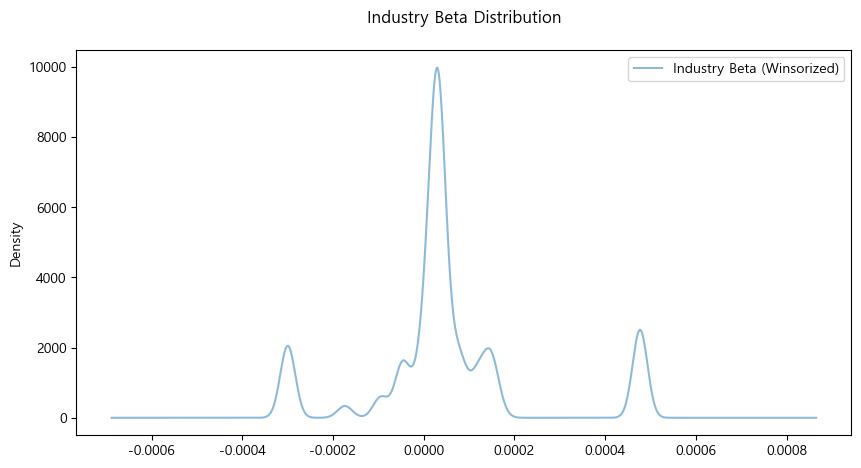

In [143]:
from scipy.stats.mstats import winsorize

filtered_data = df.loc[~df["delta_cashflow"].isna(), "beta_ind"]
winsorized_data = winsorize(filtered_data, limits=[0.05, 0.05])


pd.Series(winsorized_data).plot(
    kind="kde", alpha=0.5, figsize=(10, 5),
    label="Industry Beta (Winsorized)", legend=True, title="Industry Beta Distribution",
)

<Axes: title={'center': 'Oil Price Growth Distribution'}, ylabel='Density'>

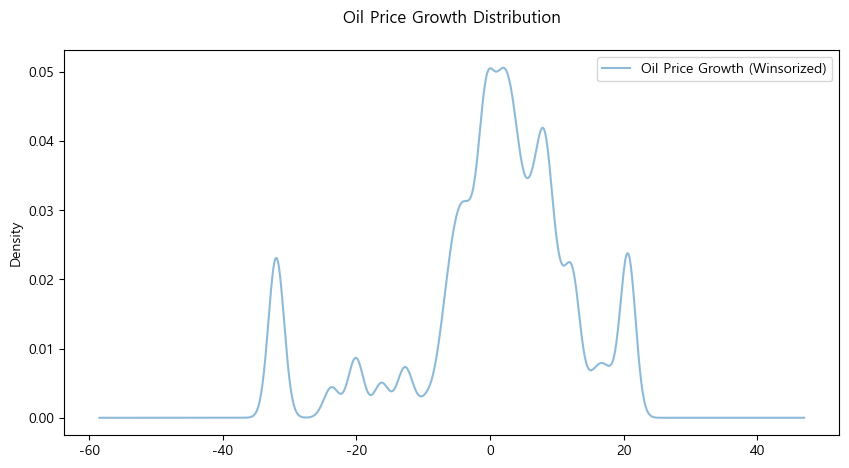

In [144]:
filtered_data = df.loc[~df["delta_cashflow"].isna(), "oil_price_growth"]
winsorized_data = winsorize(filtered_data, limits=[0.05, 0.05])


pd.Series(winsorized_data).plot(
    kind="kde", alpha=0.5, figsize=(10, 5),
    label="Oil Price Growth (Winsorized)", legend=True, title="Oil Price Growth Distribution",
)

<Axes: title={'center': 'Industry Shock Distribution [Mid-Class]'}, ylabel='Density'>

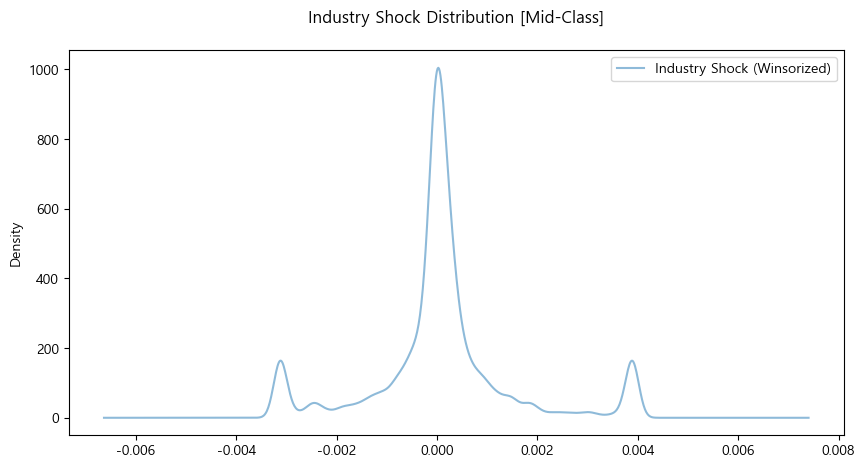

In [145]:
filtered_data = df.loc[~df["delta_cashflow"].isna(), "ind_shock"]
winsorized_data = winsorize(filtered_data, limits=[0.05, 0.05])


pd.Series(winsorized_data).plot(
    kind="kde", alpha=0.5, figsize=(10, 5),
    label="Industry Shock (Winsorized)", legend=True, title="Industry Shock Distribution [Mid-Class]",
)

<Axes: title={'center': 'Industry Shock Distribution [Mid-Class]'}, ylabel='Frequency'>

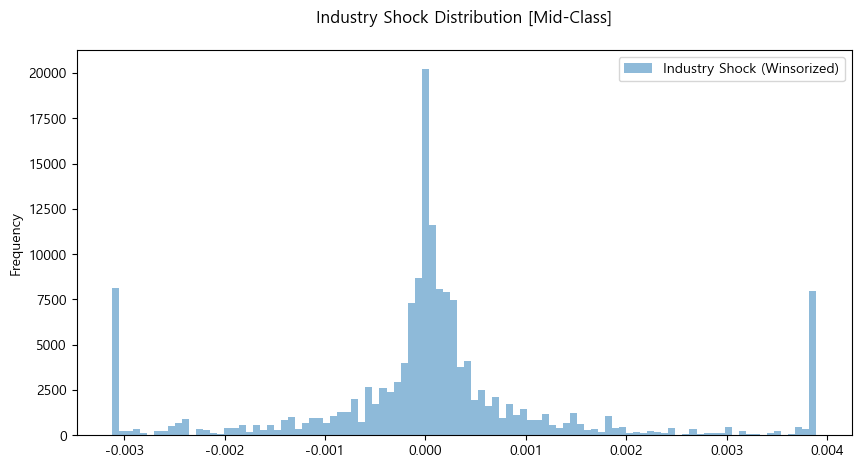

In [146]:
pd.Series(winsorized_data).plot(
    kind="hist", bins=100, alpha=0.5, figsize=(10, 5),
    label="Industry Shock (Winsorized)", legend=True, title="Industry Shock Distribution [Mid-Class]",
)

In [147]:
df.to_csv("./dataset/working_capital_dataset_oil_FF.csv", index=False, encoding="utf8")

# Table

- C(~~): Categorical Variable를 지칭 (범주형 변수)
- ! Control은 따로 명시하지 않아도 알아서 ?

In [148]:
import os

categorical_vars_path = "categorical_vars"
os.makedirs(categorical_vars_path, exist_ok=True)
categorical_vars_path = "categorical_vars" + "/multiple/FF"
os.makedirs(categorical_vars_path, exist_ok=True)

In [149]:
def _result_table(model):
    results_table = pd.DataFrame({
        'Variable': model.params.index,
        'Coefficient': model.params.values,
        't-value': model.tvalues.values,
        'p-value': model.pvalues.values,
        'observations': int(model.nobs),
        'R-squared': model.rsquared
    })
    results_table['Significance'] = results_table['p-value'].apply(
        lambda p: '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
    )
    return results_table

def summary_table(model):
    results_table = _result_table(model)
    filtered_results = results_table[~results_table['Variable'].str.contains("C\(")].reset_index(drop=True).T
    filtered_results.columns = filtered_results.loc["Variable"]
    return filtered_results.drop("Variable")

def summary_survival_table(model):
    filtered_results = _result_table(model).reset_index(drop=True)
    filtered_results = filtered_results[filtered_results["p-value"]< 0.05].reset_index(drop=True).T
    filtered_results.columns = filtered_results.loc["Variable"]
    return filtered_results.drop("Variable")

formula_str = lambda f: f"{f['Y']} ~ {' + '.join(f['X'])}"
formula_var = lambda x: [(xx[2:-1] if xx[:2]=="C(" else xx) for xx in x]

In [150]:
ta

NameError: name 'ta' is not defined

In [26]:
condition = (~df["delta_cashflow"].isna()) & (~df["firm_type"].isna()) & (df["beta_ind"]<=0)

In [27]:
# to avoid SVD did not converge error
table_cut = lambda table, col: table[table[col].map(table[col].value_counts()) > 1] 

In [28]:
import statsmodels.formula.api as smf

# 절편 없이 회귀분석
def ols_model(data, formula, title="", filter_var=None):
    if filter_var:
        data = data[data[filter_var]==1]

    temp_data = data.loc[
        (data["drop_size_dummy"]==False) 
    ].dropna(subset=[formula["Y"]])
    model = smf.ols(formula=formula_str(formula) + " + 0", data=temp_data).fit()
    if title:
        print(title)
        print(formula_str(formula) + " + 0")
        print()
        print(model.summary())
    return model

In [29]:
df["FF"] = df["FF"].str.replace("_","-")

In [30]:
def num_obs(data):
    t = data['IndustryQuarterFE'].value_counts().reset_index()
    t["industry"] = t["IndustryQuarterFE"].str.split("_").str[0]
    t["quarter"] = t["IndustryQuarterFE"].str.split("_").str[1]

    plt.figure(figsize=(20, 15))
    sns.heatmap(
        t.pivot(index="industry", columns="quarter", values="count"), annot=False, fmt=".0f", cmap="YlGnBu",
        cbar=True, square=True, xticklabels=True, yticklabels=True, 
        annot_kws={"fontsize": 7}, cbar_kws={"shrink": 0.5, "pad": 0.01}, robust=True,
    )
    plt.title(label = "Number of Observations by Industry and Quarter", fontsize=20)
    plt.xticks(rotation=45)
    plt.show()

## Table 2

In [84]:
df_table2 = df.loc[condition, [
    "firmcode", "date", "firm_type", "main_quarter", "sup_fin_tercile", 
    "oil_price_growth", "beta_firm", "beta_ind", "ind_shock", "cashflow", "cashflow_01",
    "avg_age", "avg_size", "avg_q", "avg_cashflow", "ind_code", ind_code_class, "drop_size_dummy",
    "delta_log_payab_01", "delta_log_st_asset_01", "delta_log_sales_01",
]].copy().rename(columns={
    "beta_ind": "OilExposure",
    "cashflow": "CashFlow", "cashflow_01": "CashFlow_t_plus_1", "avg_age": "Avg_Age", "avg_size": "Avg_Size", 
    "avg_q": "Avg_Q", "avg_cashflow": "Avg_CashFlow", ind_code_class: "Industry", "sup_fin_tercile": "SupFinTercile",
    "main_quarter": "MainQuarter", "firm_type": "FirmType", "oil_price_growth": "OilPriceGrowth", 
    "delta_log_payab_01": "DeltaLogAP", "delta_log_st_asset_01": "DeltaLogStAsset", "delta_log_sales_01": "DeltaLogSales"
}).dropna(subset=["FirmType", "Industry", "ind_shock", "CashFlow", "CashFlow_t_plus_1"])


### Panel A: Seasonality in Firm Profitability - Main Quarter Effect

In [85]:
df_table2['Industry'] = df_table2['Industry'].astype('category')  
df_table2['Quarter'] = df_table2['date'].astype('category')  
df_table2["FirmType"] = df_table2["FirmType"].astype('category')

df_table2['IndustryQuarterFE'] = df_table2['Industry'].astype(str) + "_" + df_table2['Quarter'].astype(str)
df_table2['IndustryQuarterFE'] = df_table2['IndustryQuarterFE'].astype('category')

In [86]:
df_table2

,firmcode,date,FirmType,MainQuarter,SupFinTercile,OilPriceGrowth,beta_firm,OilExposure,ind_shock,CashFlow,...,Avg_Q,Avg_CashFlow,ind_code,Industry,drop_size_dummy,DeltaLogAP,DeltaLogStAsset,DeltaLogSales,Quarter,IndustryQuarterFE
49820,A000490,2004-06-30,1.000000000000,0.000000000000,top,3.041046000000,-0.000143093577,-0.000299704761,-0.000911415966,0.028969927369,...,0.143300158950,0.018315867247,C,21-Mach,True,-0.029590415008,0.102184544136,0.176086370188,2004-06-30,21-Mach_2004-06-30
49830,A000720,2004-06-30,1.000000000000,0.000000000000,top,3.041046000000,0.000033431805,-0.000048560761,-0.000147675507,0.020436081075,...,0.487353529274,0.015564956679,F,18-Cnstr,True,-0.141976335533,-0.035291649001,-0.111522687156,2004-06-30,18-Cnstr_2004-06-30
49833,A000850,2004-06-30,1.000000000000,0.000000000000,top,3.041046000000,0.000064528294,-0.000299704761,-0.000911415966,0.013026763481,...,0.328476551770,0.013467345664,C,21-Mach,False,0.389049023858,0.080933661247,0.268713502242,2004-06-30,21-Mach_2004-06-30
49841,A001000,2004-06-30,1.000000000000,0.000000000000,top,3.041046000000,-0.000038027228,-0.000085934430,-0.000261330553,-0.003815379829,...,0.719904697741,-0.012147174351,L,46-RlEst,False,-1.260810145228,-0.623007152398,-0.295297501411,2004-06-30,46-RlEst_2004-06-30
49855,A001260,2004-06-30,1.000000000000,0.000000000000,top,3.041046000000,0.000203452230,-0.000048560761,-0.000147675507,0.073018287524,...,0.619157284750,0.014572275388,F,18-Cnstr,True,-0.281509507032,-0.079802174268,0.228165876059,2004-06-30,18-Cnstr_2004-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286376,A182360,2024-06-30,1.000000000000,0.000000000000,mid,12.188327400000,-0.000105165583,-0.000022754768,-0.000277342567,0.030982303062,...,2.374271036805,0.044433814522,J,8-Books,False,0.186529329502,0.193327064163,0.085142882183,2024-06-30,8-Books_2024-06-30
286402,A192390,2024-06-30,1.000000000000,0.000000000000,low,12.188327400000,-0.000039977082,-0.000095565684,-0.001164785842,0.050344904452,...,0.660023899177,0.037698129967,C,20-FabPr,False,-1.470038369971,-0.207967822923,-0.216024286331,2024-06-30,20-FabPr_2024-06-30
286428,A199430,2024-06-30,1.000000000000,0.000000000000,mid,12.188327400000,0.000391853710,-0.000173819145,-0.002118564645,-0.042032091833,...,4.577875915190,0.012399492713,C,37-LabEq,False,-0.263820523344,0.144228832186,-0.156197606503,2024-06-30,37-LabEq_2024-06-30
286584,A238120,2024-06-30,3.000000000000,0.000000000000,low,12.188327400000,0.000027747363,-0.000173819145,-0.002118564645,0.010890359012,...,1.688061932413,0.020393754315,C,37-LabEq,False,-0.595351032055,0.108823640323,-0.021011345911,2024-06-30,37-LabEq_2024-06-30


In [87]:
df_table2["Industry"].value_counts()

Industry
21-Mach     5353
18-Cnstr    3702
20-FabPr    1748
7-Fun       1236
37-LabEq    1082
6-Toys       805
33-PerSv     750
8-Books      666
35-Comps     536
30-Oil       247
46-RlEst     230
5-Smoke       75
Name: count, dtype: int64

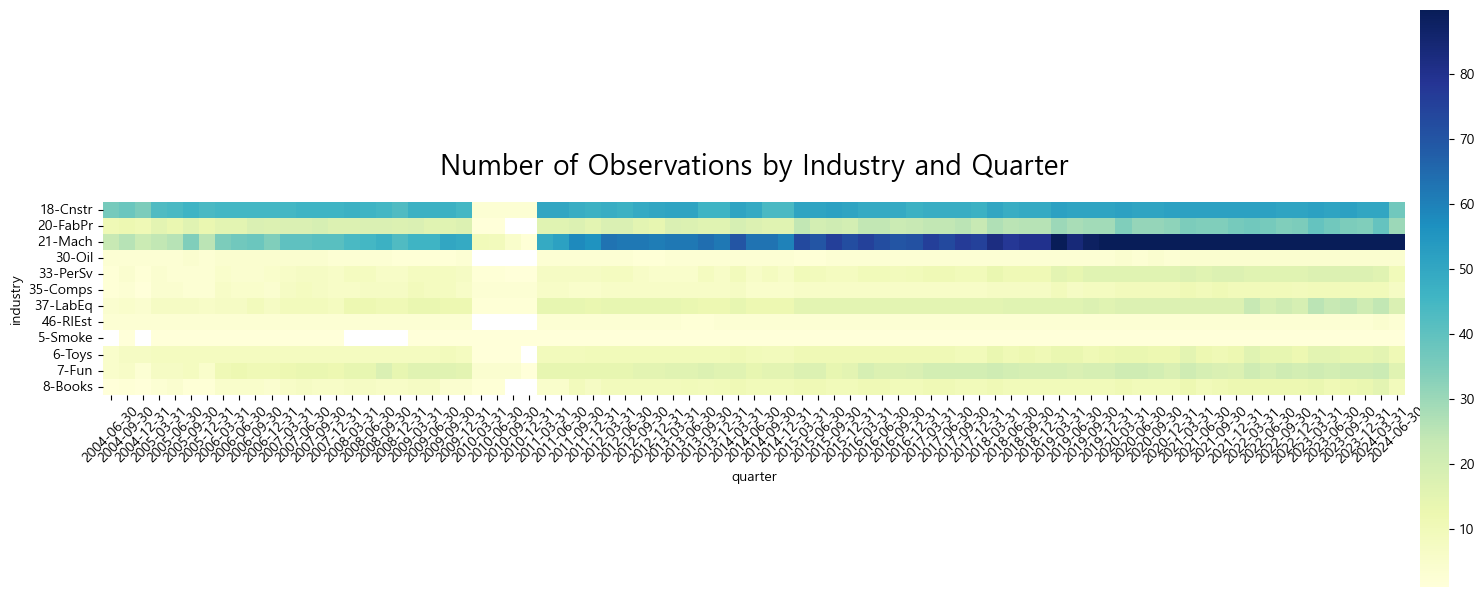

In [88]:
num_obs(df_table2)

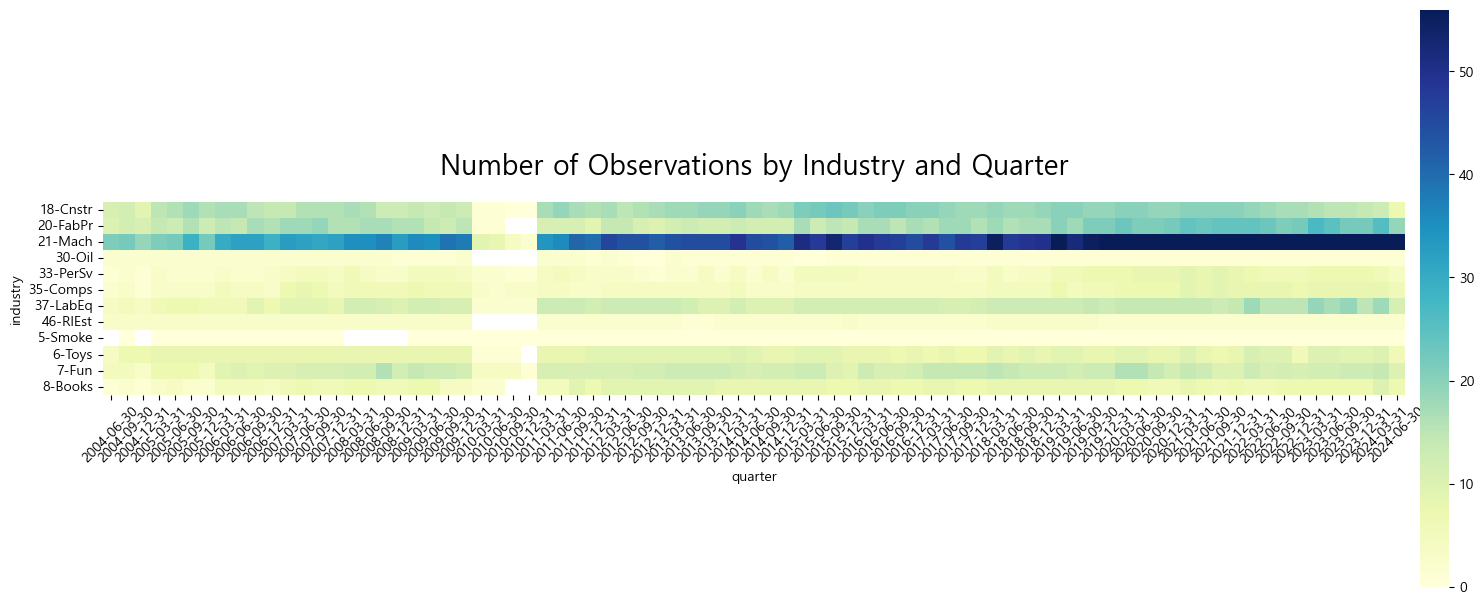

In [89]:
num_obs(df_table2[df_table2["drop_size_dummy"]==False])

In [90]:
# t["IndustryQuarterFE"].value_counts().sort_index()

In [91]:
# interaction_counts = df_table2.groupby(['IndustryQuarterFE', 'FirmType'], observed=False).size()
# print(interaction_counts[interaction_counts <= 3].reset_index()["IndustryQuarterFE"].unique())  # 빈도가 낮은 조합 확인

In [151]:
df_table2[df_table2["drop_size_dummy"]==False]["firmcode"].nunique()

337

In [152]:
df_table2[condition].shape

C:\Users\DYK\AppData\Local\Temp\ipykernel_30740\2883591878.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_table2[condition].shape


(6015, 36)

In [153]:
df_table2_a = df_table2 #table_cut(df_table2, "IndustryQuarterFE")

##### Industry by Industry

In [154]:
formula_t = {
    "X": [
        "MainQuarter", "C(Quarter)", "C(FirmType)"
    ],
    "Y": "CashFlow"
}


formula_t_plus_1 = {
    "X": [
        "MainQuarter", "C(Quarter)", "C(FirmType)"
    ],
    "Y": "CashFlow_t_plus_1"
}

print(formula_str(formula_t), formula_var(formula_t["X"]))

CashFlow ~ MainQuarter + C(Quarter) + C(FirmType) ['MainQuarter', 'Quarter', 'FirmType']


In [187]:

def summary_table(model):
    results_table = _result_table(model)
    filtered_results = results_table[~results_table['Variable'].str.contains("C\(")].reset_index(drop=True).T
    filtered_results.columns = filtered_results.loc["Variable"]
    return filtered_results.drop("Variable")

In [188]:
model_result_t = {ind: None for ind in df_table2["Industry"].sort_values().unique()}
model_result_t1 = {ind: None for ind in df_table2["Industry"].sort_values().unique()}

In [192]:
for ind, group in df_table2.groupby("Industry"):
    # print(ind, group.shape)
    print(ind)
    try:
        model_result_t[ind] = summary_table(ols_model(group, formula_t)).copy()
        model_result_t[ind]["Industry"] = ind
        
    except Exception as e:
        print("Error", e)
        model_result_t[ind] = None

    try:
        model_result_t1[ind] = summary_table(ols_model(group, formula_t_plus_1))
        model_result_t1[ind]["Industry"] = ind
        print(model_result_t1[ind])
    except Exception as e:
        print("Error", e)
        model_result_t1[ind] = None


C:\Users\DYK\AppData\Local\Temp\ipykernel_30740\3694812001.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ind, group in df_table2.groupby("Industry"):


18-Cnstr
Variable        MainQuarter  Industry
Coefficient  0.000827509488  18-Cnstr
t-value      0.298267651825  18-Cnstr
p-value      0.765548821492  18-Cnstr
observations           1324  18-Cnstr
R-squared    0.102758076030  18-Cnstr
Significance                 18-Cnstr
20-FabPr
Variable         MainQuarter  Industry
Coefficient  -0.002841067488  20-FabPr
t-value      -1.112692285261  20-FabPr
p-value       0.266061982079  20-FabPr
observations            1291  20-FabPr
R-squared     0.117756527469  20-FabPr
Significance                  20-FabPr
21-Mach
Variable        MainQuarter Industry
Coefficient  0.000568000126  21-Mach
t-value      0.307991889080  21-Mach
p-value      0.758106670364  21-Mach
observations           3616  21-Mach
R-squared    0.053852954999  21-Mach
Significance                 21-Mach
30-Oil
Variable         MainQuarter Industry
Coefficient  -0.028326463034   30-Oil
t-value      -1.100529534833   30-Oil
p-value       0.284171504076   30-Oil
observations     

In [191]:
pd.concat(list(model_result_t.values()), axis=1)

Variable,MainQuarter,Industry,MainQuarter,Industry,MainQuarter,Industry,MainQuarter,Industry,MainQuarter,Industry,...,MainQuarter,Industry,MainQuarter,Industry,MainQuarter,Industry,MainQuarter,Industry,MainQuarter,Industry
Coefficient,0.000095886327,18-Cnstr,-0.001248135108,20-FabPr,0.000612557958,21-Mach,-0.010042994639,30-Oil,-0.000562954798,33-PerSv,...,0.001583494080,37-LabEq,0.002245145914,46-RlEst,-0.000275400923,6-Toys,0.000453895309,7-Fun,-0.000942654767,8-Books
t-value,0.058687593634,18-Cnstr,-0.885203868989,20-FabPr,0.577189374050,21-Mach,-0.729303271947,30-Oil,-0.112568376497,33-PerSv,...,0.858573416370,37-LabEq,0.571038729960,46-RlEst,-0.115910396131,6-Toys,0.189532195436,7-Fun,-0.251551156922,8-Books
p-value,0.953210389503,18-Cnstr,0.376222849064,20-FabPr,0.563848331754,21-Mach,0.474271313952,30-Oil,0.910458303834,33-PerSv,...,0.390824983242,37-LabEq,0.569229413126,46-RlEst,0.907765257502,6-Toys,0.849722570724,7-Fun,0.801506536796,8-Books
observations,1324,18-Cnstr,1291,20-FabPr,3616,21-Mach,97,30-Oil,349,33-PerSv,...,911,37-LabEq,183,46-RlEst,642,6-Toys,906,7-Fun,519,8-Books
R-squared,0.090458248317,18-Cnstr,0.110686426529,20-FabPr,0.047071508984,21-Mach,0.783767664664,30-Oil,0.221988860602,33-PerSv,...,0.124179165525,37-LabEq,0.446640540752,46-RlEst,0.126486632385,6-Toys,0.122091926720,7-Fun,0.203249517819,8-Books
Significance,,18-Cnstr,,20-FabPr,,21-Mach,,30-Oil,,33-PerSv,...,,37-LabEq,,46-RlEst,,6-Toys,,7-Fun,,8-Books


In [186]:
df_multi_index = pd.concat(list(model_result_t.values())).set_index(["Industry", "Variable"]).unstack(level=0)
df_multi_index.columns = df_multi_index.columns.reorder_levels([1, 0])
df_multi_index = df_multi_index.sort_index(axis=1)

print(df_multi_index)

KeyError: "None of ['Variable'] are in the columns"

##### Original

In [95]:
formula_t = {
    "X": [
        "MainQuarter", "C(IndustryQuarterFE)", "C(FirmType)"
    ],
    "Y": "CashFlow"
}


formula_t_plus_1 = {
    "X": [
        "MainQuarter", "C(IndustryQuarterFE)", "C(FirmType)"
    ],
    "Y": "CashFlow_t_plus_1"
}

print(formula_str(formula_t), formula_var(formula_t["X"]))

CashFlow ~ MainQuarter + C(IndustryQuarterFE) + C(FirmType) ['MainQuarter', 'IndustryQuarterFE', 'FirmType']


In [99]:
print("Table II - Panel A")
print()
for v in [formula_t, formula_t_plus_1]:
    print(v)
    print(formula_str(v))
    print()

Table II - Panel A

{'X': ['MainQuarter', 'C(IndustryQuarterFE)', 'C(FirmType)'], 'Y': 'CashFlow'}
CashFlow ~ MainQuarter + C(IndustryQuarterFE) + C(FirmType)

{'X': ['MainQuarter', 'C(IndustryQuarterFE)', 'C(FirmType)'], 'Y': 'CashFlow_t_plus_1'}
CashFlow_t_plus_1 ~ MainQuarter + C(IndustryQuarterFE) + C(FirmType)



In [77]:
# df_table2_a[df_table2_a[formula_t["Y"]].notna()]["Industry"].value_counts().to_frame().sort_index().T

In [78]:
df_table2_a[df_table2_a[formula_t["Y"]].notna()][["drop_size_dummy", "SupFinTercile"]].value_counts().to_frame().sort_index(ascending=False)

count
drop_size_dummy SupFinTercile       
True            top             3090
                mid             1595
                low             1495
False           top             4217
                mid             3359
                low             2661

In [79]:
model_t = ols_model(
    df_table2_a, formula_t, title = "Table II - Panel A (1): Cash Flow (t)"
)
summary_survival_table(model_t).T.to_csv(f"./{categorical_vars_path}/t2_a_1.csv")

Table II - Panel A (1): Cash Flow (t)
CashFlow ~ MainQuarter + C(IndustryQuarterFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:               CashFlow   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     2.077
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           2.52e-59
Time:                        15:55:52   Log-Likelihood:                 23440.
No. Observations:               10250   AIC:                        -4.513e+04
Df Residuals:                    9374   BIC:                        -3.879e+04
Df Model:                         875                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.97

In [80]:
summary_table(model_t)

Variable,MainQuarter
Coefficient,0.000095430256
t-value,0.151335869124
p-value,0.879714032152
observations,10250
R-squared,0.162402160786
Significance,


In [81]:
# df_table2_a = table_cut(df_table2, "IndustryQuarterFE")

In [82]:
model_t_plus_1 = ols_model(
    df_table2_a, formula_t_plus_1, title = "Table II - Panel A (2): Cash Flow (t, t+1)"
)
summary_survival_table(model_t_plus_1).T.to_csv(f"./{categorical_vars_path}/t2_a_2.csv")

Table II - Panel A (2): Cash Flow (t, t+1)
CashFlow_t_plus_1 ~ MainQuarter + C(IndustryQuarterFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:      CashFlow_t_plus_1   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     2.331
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           2.87e-81
Time:                        15:55:57   Log-Likelihood:                 17730.
No. Observations:               10250   AIC:                        -3.371e+04
Df Residuals:                    9374   BIC:                        -2.737e+04
Df Model:                         875                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0

In [83]:
summary_table(model_t_plus_1)

Variable,MainQuarter
Coefficient,-0.000653485552
t-value,-0.593686608078
p-value,0.552736066724
observations,10250
R-squared,0.178723966491
Significance,


### Panel B

In [100]:
df_table2["TopSupFin"] = (df_table2["SupFinTercile"] == "top").astype(int)
df_table2["MidSupFin"] = (df_table2["SupFinTercile"] == "mid").astype(int)

df_table2["APStAsset"] = df_table2["DeltaLogAP"] - df_table2["DeltaLogStAsset"]
df_table2["APSales"] = df_table2["DeltaLogAP"] - df_table2["DeltaLogSales"]

In [101]:
df_table2['Industry'] = df_table2['Industry'].astype('category')  
df_table2['Quarter'] = df_table2['date'].astype('category')  
df_table2["FirmType"] = df_table2["FirmType"].astype('category')
df_table2["SupFinTercile"] = df_table2["SupFinTercile"].astype('category')
df_table2["MQuarter"] = df_table2["MainQuarter"].astype('category')

df_table2["MQuarterAvgAge"] = df_table2["MainQuarter"] * df_table2["Avg_Age"]
df_table2["MQuarterAvgSize"] = df_table2["MainQuarter"] * df_table2["Avg_Size"]
df_table2["MQuarterAvgQ"] = df_table2["MainQuarter"] * df_table2["Avg_Q"]
df_table2["MQuarterAvgCashFlow"] = df_table2["MainQuarter"] * df_table2["Avg_CashFlow"]


df_table2['IndustryQuarterFE'] = df_table2['Industry'].astype(str) + "_" + df_table2['Quarter'].astype(str)
df_table2["IndustryQuarterSupFinTercileFE"] = df_table2["IndustryQuarterFE"] + "_" + df_table2["SupFinTercile"].astype(str)
df_table2["IndustryQuarterTopSupFinFE"] = df_table2["IndustryQuarterFE"] + "_" + df_table2["TopSupFin"].astype('category').astype(str)

df_table2["MainQuaterXTopSupFin"] = df_table2["MainQuarter"] * df_table2["TopSupFin"]
df_table2["MainQuaterXMidSupFin"] = df_table2["MainQuarter"] * df_table2["MidSupFin"]

for v in [
    "IndustryQuarterFE", "IndustryQuarterSupFinTercileFE", "IndustryQuarterTopSupFinFE"
]:
    df_table2[v] = df_table2[v].astype('category')

# df_table2 = df_table2[df_table2['IndustryQuarterSupFinTercileFE'].map(df_table2['IndustryQuarterSupFinTercileFE'].value_counts()) > 2]

df_table2_b = df_table2 #table_cut(df_table2, "IndustryQuarterSupFinTercileFE")
df_table2_b5 = df_table2 #table_cut(df_table2, "IndustryQuarterTopSupFinFE")

In [102]:
formula_1 = {
    "X": [
        "MainQuaterXTopSupFin", "MainQuaterXMidSupFin",
        "C(IndustryQuarterSupFinTercileFE)", "C(FirmType)"  # Control Variables
    ],
    "Y": "APStAsset"
}

formula_2 = {
    "X": [
        "MainQuaterXTopSupFin", "MainQuaterXMidSupFin",
        "MQuarterAvgAge", "MQuarterAvgSize", "MQuarterAvgQ", # Control Variables
        "C(IndustryQuarterSupFinTercileFE)", "C(FirmType)"  # Control Variables
    ],
    "Y": formula_1["Y"]
}



formula_3 = {
    "X": [
        "MainQuaterXTopSupFin",
        "C(IndustryQuarterTopSupFinFE)", "C(FirmType)"
    ],
    "Y": formula_1["Y"]
}

formula_4 = {
    "X": [
        "MainQuaterXTopSupFin", 
        "MQuarterAvgAge", "MQuarterAvgSize", "MQuarterAvgQ", # Control Variables
        "C(IndustryQuarterTopSupFinFE)", "C(FirmType)"  # Control Variables
    ],
    "Y": formula_1["Y"]
}


formula_5 = {
    "X": [
        "MainQuaterXTopSupFin",
        "C(IndustryQuarterTopSupFinFE)", "C(FirmType)"
    ],
    "Y": "APSales"
}

formula_6 = {
    "X": [
        "MainQuaterXTopSupFin",
        "MQuarterAvgAge", "MQuarterAvgSize", "MQuarterAvgQ", # Control Variables
        "C(IndustryQuarterTopSupFinFE)", "C(FirmType)"
    ],
    "Y": formula_5["Y"]
}

print(formula_str(formula_5))
print(formula_var(formula_5["X"]))

APSales ~ MainQuaterXTopSupFin + C(IndustryQuarterTopSupFinFE) + C(FirmType)
['MainQuaterXTopSupFin', 'IndustryQuarterTopSupFinFE', 'FirmType']


In [103]:
print("Table II - Panel B")
print()
for i, v in enumerate([formula_1, formula_2, formula_3, formula_4, formula_5, formula_6]):
    print(i, v)
    print(formula_str(v))
    print()

Table II - Panel B

0 {'X': ['MainQuaterXTopSupFin', 'MainQuaterXMidSupFin', 'C(IndustryQuarterSupFinTercileFE)', 'C(FirmType)'], 'Y': 'APStAsset'}
APStAsset ~ MainQuaterXTopSupFin + MainQuaterXMidSupFin + C(IndustryQuarterSupFinTercileFE) + C(FirmType)

1 {'X': ['MainQuaterXTopSupFin', 'MainQuaterXMidSupFin', 'MQuarterAvgAge', 'MQuarterAvgSize', 'MQuarterAvgQ', 'C(IndustryQuarterSupFinTercileFE)', 'C(FirmType)'], 'Y': 'APStAsset'}
APStAsset ~ MainQuaterXTopSupFin + MainQuaterXMidSupFin + MQuarterAvgAge + MQuarterAvgSize + MQuarterAvgQ + C(IndustryQuarterSupFinTercileFE) + C(FirmType)

2 {'X': ['MainQuaterXTopSupFin', 'C(IndustryQuarterTopSupFinFE)', 'C(FirmType)'], 'Y': 'APStAsset'}
APStAsset ~ MainQuaterXTopSupFin + C(IndustryQuarterTopSupFinFE) + C(FirmType)

3 {'X': ['MainQuaterXTopSupFin', 'MQuarterAvgAge', 'MQuarterAvgSize', 'MQuarterAvgQ', 'C(IndustryQuarterTopSupFinFE)', 'C(FirmType)'], 'Y': 'APStAsset'}
APStAsset ~ MainQuaterXTopSupFin + MQuarterAvgAge + MQuarterAvgSize + MQua

In [279]:
model_1 = ols_model(
    df_table2_b, formula_1, title = "Table II - Panel B (1): Delta Log AP - Delta Log St Asset"
) 
summary_survival_table(model_1).T.to_csv(f"./{categorical_vars_path}/t2_b_1.csv")

Table II - Panel B (1): Delta Log AP - Delta Log St Asset
APStAsset ~ MainQuaterXTopSupFin + MainQuaterXMidSupFin + C(IndustryQuarterSupFinTercileFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:              APStAsset   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.282
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           7.32e-14
Time:                        06:43:02   Log-Likelihood:                -24429.
No. Observations:               10552   AIC:                         5.305e+04
Df Residuals:                    8455   BIC:                         6.828e+04
Df Model:                        2096                                         
Covariance Type:            nonrobust                                         
                                         

In [280]:
summary_table(model_1)

Variable,MainQuaterXTopSupFin,MainQuaterXMidSupFin
Coefficient,-0.050721953732,-0.085948358963
t-value,-0.479060973629,-0.690378801381
p-value,0.631907641458,0.489974954510
observations,10552,10552
R-squared,0.241207183406,0.241207183406
Significance,,


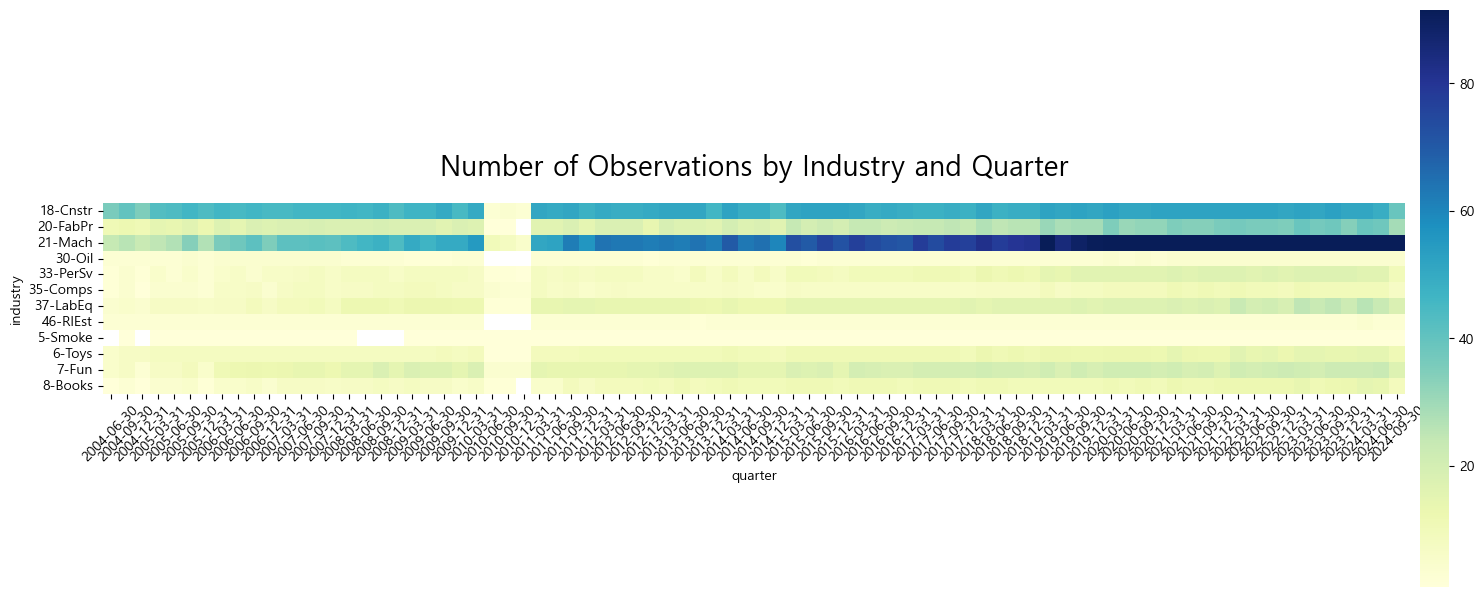

In [281]:
# df_table2_b = table_cut(df_table2_b, "IndustryQuarterSupFinTercileFE")
num_obs(df_table2_b)

In [168]:
df_table2_b2 = table_cut(df_table2_b, "IndustryQuarterSupFinTercileFE")

In [167]:
formula_2

{'X': ['MainQuaterXTopSupFin',
  'MainQuaterXMidSupFin',
  'MQuarterAvgAge',
  'MQuarterAvgSize',
  'MQuarterAvgQ',
  'C(IndustryQuarterSupFinTercileFE)',
  'C(FirmType)'],
 'Y': 'APStAsset'}

In [283]:
model_2 = ols_model(
    df_table2_b, formula_2, title = "Table II - Panel B (2): Delta Log AP - Delta Log St Asset"
) 
summary_survival_table(model_2).T.to_csv(f"./{categorical_vars_path}/t2_b_2.csv")

Table II - Panel B (2): Delta Log AP - Delta Log St Asset
APStAsset ~ MainQuaterXTopSupFin + MainQuaterXMidSupFin + MQuarterAvgAge + MQuarterAvgSize + MQuarterAvgQ + C(IndustryQuarterSupFinTercileFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:              APStAsset   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.281
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           8.22e-14
Time:                        06:43:38   Log-Likelihood:                -24427.
No. Observations:               10552   AIC:                         5.305e+04
Df Residuals:                    8452   BIC:                         6.831e+04
Df Model:                        2099                                         
Covariance Type:            nonrobust                                 

In [284]:
summary_table(model_2)

Variable,MainQuaterXTopSupFin,MainQuaterXMidSupFin,MQuarterAvgAge,MQuarterAvgSize,MQuarterAvgQ
Coefficient,0.138371838280,0.101936183971,0.003374475026,-0.012726275644,0.023857973836
t-value,0.761379435618,0.528008989759,0.658509526640,-1.445994420414,0.424558276963
p-value,0.446451709219,0.597506958093,0.510228714473,0.148215845744,0.671169520333
observations,10552,10552,10552,10552,10552
R-squared,0.241418320618,0.241418320618,0.241418320618,0.241418320618,0.241418320618
Significance,,,,,


In [285]:
model_3 = ols_model(
    df_table2_b, formula_3, title = "Table II - Panel B (3): Delta Log AP - Delta Log St Asset"
) 
summary_survival_table(model_3).T.to_csv(f"./{categorical_vars_path}/t2_b_3.csv")

Table II - Panel B (3): Delta Log AP - Delta Log St Asset
APStAsset ~ MainQuaterXTopSupFin + C(IndustryQuarterTopSupFinFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:              APStAsset   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.126
Date:                Tue, 17 Dec 2024   Prob (F-statistic):            0.00118
Time:                        06:43:59   Log-Likelihood:                -24999.
No. Observations:               10552   AIC:                         5.295e+04
Df Residuals:                    9077   BIC:                         6.366e+04
Df Model:                        1474                                         
Covariance Type:            nonrobust                                         
                                                           coef    s

In [286]:
summary_table(model_3)

Variable,MainQuaterXTopSupFin
Coefficient,-0.050795879668
t-value,-0.470942799716
p-value,0.637692900074
observations,10552
R-squared,0.154586729777
Significance,


In [287]:
model_4 = ols_model(
    df_table2_b, formula_4, title = "Table II - Panel B (4): Delta Log AP - Delta Log St Asset"
) 
summary_survival_table(model_4).T.to_csv(f"./{categorical_vars_path}/t2_b_4.csv")

Table II - Panel B (4): Delta Log AP - Delta Log St Asset
APStAsset ~ MainQuaterXTopSupFin + MQuarterAvgAge + MQuarterAvgSize + MQuarterAvgQ + C(IndustryQuarterTopSupFinFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:              APStAsset   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.124
Date:                Tue, 17 Dec 2024   Prob (F-statistic):            0.00133
Time:                        06:44:10   Log-Likelihood:                -24998.
No. Observations:               10552   AIC:                         5.295e+04
Df Residuals:                    9074   BIC:                         6.369e+04
Df Model:                        1477                                         
Covariance Type:            nonrobust                                         
                  

In [288]:
summary_table(model_4)

Variable,MainQuaterXTopSupFin,MQuarterAvgAge,MQuarterAvgSize,MQuarterAvgQ
Coefficient,0.037805756428,0.002209250810,-0.006207006307,-0.001107460767
t-value,0.267397527046,0.438543740982,-0.813453083803,-0.020241720132
p-value,0.789169180408,0.661002609735,0.415979678533,0.983850991895
observations,10552,10552,10552,10552
R-squared,0.154703395756,0.154703395756,0.154703395756,0.154703395756
Significance,,,,


In [289]:
model_5 = ols_model(
    df_table2_b5, formula_5, title = "Table II - Panel B (5): Delta Log AP - Delta Log Sales"
) 
summary_survival_table(model_5).T.to_csv(f"./{categorical_vars_path}/t2_b_5.csv")

Table II - Panel B (5): Delta Log AP - Delta Log Sales
APSales ~ MainQuaterXTopSupFin + C(IndustryQuarterTopSupFinFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:                APSales   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.097
Date:                Tue, 17 Dec 2024   Prob (F-statistic):            0.00911
Time:                        06:44:20   Log-Likelihood:                -25670.
No. Observations:               10614   AIC:                         5.429e+04
Df Residuals:                    9139   BIC:                         6.501e+04
Df Model:                        1474                                         
Covariance Type:            nonrobust                                         
                                                           coef    std er

In [290]:
summary_table(model_5)

Variable,MainQuaterXTopSupFin
Coefficient,-0.090835319808
t-value,-0.801445061127
p-value,0.422894873709
observations,10614
R-squared,0.150299966028
Significance,


In [291]:
# df_table2_b5 = table_cut(df_table2_b5, "IndustryQuarterTopSupFinFE")

In [292]:
formula_str(formula_6)

'APSales ~ MainQuaterXTopSupFin + MQuarterAvgAge + MQuarterAvgSize + MQuarterAvgQ + C(IndustryQuarterTopSupFinFE) + C(FirmType)'

In [293]:
model_6 = ols_model(
    df_table2_b5, formula_6, title = "Table II - Panel B (6): Delta Log AP - Delta Log Sales"
) 
summary_survival_table(model_6).T.to_csv(f"./{categorical_vars_path}/t2_b_6.csv")

Table II - Panel B (6): Delta Log AP - Delta Log Sales
APSales ~ MainQuaterXTopSupFin + MQuarterAvgAge + MQuarterAvgSize + MQuarterAvgQ + C(IndustryQuarterTopSupFinFE) + C(FirmType) + 0

                            OLS Regression Results                            
Dep. Variable:                APSales   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.095
Date:                Tue, 17 Dec 2024   Prob (F-statistic):             0.0102
Time:                        06:44:36   Log-Likelihood:                -25670.
No. Observations:               10614   AIC:                         5.430e+04
Df Residuals:                    9136   BIC:                         6.504e+04
Df Model:                        1477                                         
Covariance Type:            nonrobust                                         
                       

In [294]:
summary_table(model_6)

Variable,MainQuaterXTopSupFin,MQuarterAvgAge,MQuarterAvgSize,MQuarterAvgQ
Coefficient,-0.004699208918,0.001413937454,-0.005577971609,0.009386092571
t-value,-0.031681673583,0.267659764937,-0.697299413168,0.162181492253
p-value,0.974726601973,0.788967265158,0.485633178632,0.871166520489
observations,10614,10614,10614,10614
R-squared,0.150387003733,0.150387003733,0.150387003733,0.150387003733
Significance,,,,


# Table 3

In [104]:
df_table3 = df.loc[condition, [
    "firmcode", "date", "firm_type", "main_quarter", "sup_fin_tercile", 
    "ind_shock", "cashflow", "oil_price_growth", "beta_ind",
    "avg_age", "avg_size", "avg_q", "avg_cashflow", "ind_code", ind_code_class, "drop_size_dummy",
    "delta_log_sales_01", "delta_log_sales_23",
    "age",
]].copy().rename(columns={
    "cashflow": "CashFlow", "avg_age": "Avg_Age", "avg_size": "Avg_Size", 
    "avg_q": "Avg_Q", "avg_cashflow": "Avg_CashFlow", ind_code_class: "Industry", "sup_fin_tercile": "SupFinTercile",
    "main_quarter": "MainQuarter", "firm_type": "FirmType",  
    "ind_shock": "IndustryShock", "age": "FirmAge",  "oil_price_growth": "OilPriceGrowth", "beta_ind": "OilExposure",
    "delta_log_sales_23": "DeltaLogSales23", "delta_log_sales_01": "DeltaLogSales01"
}).dropna(subset=["FirmType", "Industry"])

In [105]:
df_table3["TopSupFin"] = (df_table3["SupFinTercile"] == "top").astype(int)
df_table3["MidSupFin"] = (df_table3["SupFinTercile"] == "mid").astype(int)
df_table3["BottomSupFin"] = (df_table3["SupFinTercile"] == "low").astype(int)

df_table3['Industry'] = df_table3['Industry'].astype('category')  
df_table3['Quarter'] = df_table3['date'].astype('category')  

df_table3["IndustryShockXMainQuarter"] = df_table3["IndustryShock"] * df_table3["MainQuarter"]
df_table3["IndustryShockXMainQuarterXTopSupFin"] = df_table3["IndustryShockXMainQuarter"] * df_table3["TopSupFin"]

df_table3['IndustryQuarterFE'] = df_table3['Industry'].astype(str) + "_" + df_table3['Quarter'].astype(str)
df_table3["IndustryQuarterTopSupFinFE"] = df_table3["IndustryQuarterFE"] + "_" + df_table3["TopSupFin"].astype('category').astype(str)


In [106]:

# Shock by Firm Type FE
for i in range(1, 5):   
    df_table3[f"Q{i}"] = (df_table3["FirmType"] == i).astype(int)
for v in ["OilExposure", "OilPriceGrowth", "IndustryShock"]:
    for i in range(1, 5):   
        df_table3[f"{v}XQ{i}"] = df_table3[v] * df_table3[f"Q{i}"]

for v in ["OilExposure", "OilPriceGrowth", "IndustryShock"]:
    df_table3[f"{v}XMQuarterXAvgAge"] = df_table3["MainQuarter"] * df_table3[v] * df_table3["Avg_Age"]


In [107]:
shock_by_mquarter_by_firm_age_FE = [
    f"{category}XMQuarterXAvgAge" 
    for category in ["OilExposure", "OilPriceGrowth", "IndustryShock"]
]

shock_by_firm_type_FE = [
    f"{category}XQ{i}" 
    for category in ["OilExposure", "OilPriceGrowth", "IndustryShock"] 
    for i in range(1, 5)
]

In [108]:
df_table3_a = df_table3 #table_cut(df_table3, "IndustryQuarterFE")
df_table3_b = df_table3 #table_cut(df_table3, "IndustryQuarterTopSupFinFE")

In [109]:
df_table3_a.loc[df_table3_a["drop_size_dummy"]==False]["firmcode"].nunique()

343

In [110]:
df_table3_a.loc[df_table3_a["drop_size_dummy"]==False].groupby("SupFinTercile")["firmcode"].nunique()

SupFinTercile
low    183
mid    245
top    243
Name: firmcode, dtype: int64

In [111]:
df_table3_a.groupby("Industry")["firmcode"].nunique()

C:\Users\DYK\AppData\Local\Temp\ipykernel_30740\4184161346.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_table3_a.groupby("Industry")["firmcode"].nunique()


Industry
18-Cnstr     67
20-FabPr     49
21-Mach     149
30-Oil        5
33-PerSv     20
35-Comps     19
37-LabEq     33
46-RlEst      4
5-Smoke       1
6-Toys       17
7-Fun        36
8-Books      21
Name: firmcode, dtype: int64

### Panel A

In [112]:
formula_123 = {
    "X": [
        "IndustryShockXMainQuarter", 
        "C(IndustryQuarterFE)", # Control Variables
    ] + shock_by_firm_type_FE,
    "Y": "DeltaLogSales01"
}

formula_456 = {
    "X": formula_123["X"],
    "Y": "DeltaLogSales23"
}

print(formula_str(formula_123))
print(formula_var(formula_123["X"]))

DeltaLogSales01 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4
['IndustryShockXMainQuarter', 'IndustryQuarterFE', 'OilExposureXQ1', 'OilExposureXQ2', 'OilExposureXQ3', 'OilExposureXQ4', 'OilPriceGrowthXQ1', 'OilPriceGrowthXQ2', 'OilPriceGrowthXQ3', 'OilPriceGrowthXQ4', 'IndustryShockXQ1', 'IndustryShockXQ2', 'IndustryShockXQ3', 'IndustryShockXQ4']


In [123]:
print("Table III - Panel A")
print()
for i, v in enumerate([formula_123, formula_456]):
    print(i, v)
    print(formula_str(v))
    for ii, vv in enumerate(["top", "mid", "low"]):
        print("\ton", vv, "~", i*ii)
    print()

Table III - Panel A

0 {'X': ['IndustryShockXMainQuarter', 'C(IndustryQuarterFE)', 'OilExposureXQ1', 'OilExposureXQ2', 'OilExposureXQ3', 'OilExposureXQ4', 'OilPriceGrowthXQ1', 'OilPriceGrowthXQ2', 'OilPriceGrowthXQ3', 'OilPriceGrowthXQ4', 'IndustryShockXQ1', 'IndustryShockXQ2', 'IndustryShockXQ3', 'IndustryShockXQ4'], 'Y': 'DeltaLogSales01'}
DeltaLogSales01 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4
	on top ~ 0
	on mid ~ 0
	on low ~ 0

1 {'X': ['IndustryShockXMainQuarter', 'C(IndustryQuarterFE)', 'OilExposureXQ1', 'OilExposureXQ2', 'OilExposureXQ3', 'OilExposureXQ4', 'OilPriceGrowthXQ1', 'OilPriceGrowthXQ2', 'OilPriceGrowthXQ3', 'OilPriceGrowthXQ4', 'IndustryShockXQ1', 'IndustryShockXQ2', 'IndustryShockXQ3', 'IndustryShockXQ4'], 'Y': 'DeltaLogSales23'}
Delta

In [301]:
model_1 = ols_model(
    df_table3[df_table3["TopSupFin"]==1], 
    formula_123, title = "Table III - Panel A (1): Delta Log Sales (t, t+1) ~ TopSupFin"
)
summary_survival_table(model_1).T.to_csv(f"./{categorical_vars_path}/t3_a_1.csv")

Table III - Panel A (1): Delta Log Sales (t, t+1) ~ TopSupFin
DeltaLogSales01 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales01   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     2.460
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           6.12e-60
Time:                        06:44:41   Log-Likelihood:                -3204.9
No. Observations:                4427   AIC:                             7648.
Df Residuals:                    3808   BIC:                         1.161e+04
Df Model: 

In [302]:
summary_table(model_1)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,-6.962687213711,33.120373885095,36.474702360549,2.182058284802,-71.775845167379,0.003135507795,-0.000955381792,0.002266036923,-0.002841667973,5.086674035082,1.236749756449,7.055130570306,-13.372803891749
t-value,-1.405637825137,0.534972574089,0.563704587790,0.031119762031,-0.993338537440,1.843347280820,-0.535573536324,1.092377145386,-1.418733338697,0.796779074431,0.187773112988,0.839003289696,-1.661503216397
p-value,0.159913279672,0.592700058323,0.572988388021,0.975175660334,0.320608117021,0.065355983548,0.592284599199,0.274736468148,0.156058611346,0.425629023043,0.851064518041,0.401520127950,0.096694738028
observations,4427,4427,4427,4427,4427,4427,4427,4427,4427,4427,4427,4427,4427
R-squared,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691,0.285324232691
Significance,,,,,,*,,,,,,,*


In [303]:
model_2 = ols_model(
    df_table3[df_table3["MidSupFin"]==1], 
    formula_123, title = "Table III - Panel A (2): Delta Log Sales (t, t+1) ~ MidSupFin"
)
summary_survival_table(model_2).T.to_csv(f"./{categorical_vars_path}/t3_a_2.csv")

Table III - Panel A (2): Delta Log Sales (t, t+1) ~ MidSupFin
DeltaLogSales01 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales01   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.195
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           0.000919
Time:                        06:44:44   Log-Likelihood:                -1769.1
No. Observations:                3510   AIC:                             5034.
Df Residuals:                    2762   BIC:                             9644.
Df Model: 

In [304]:
summary_table(model_2)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,5.235814158114,48.488803683866,4.591307127247,15.304279798499,-68.378560745021,0.000933453692,0.000534183894,0.001073647882,0.001260114791,-0.910401805138,-4.605670312420,6.354020040671,-0.859192802507
t-value,1.075699152272,0.839830611232,0.075447250376,0.243124042053,-1.103498662375,0.624411326637,0.369277745289,0.706494524495,0.735903138394,-0.170453440403,-0.761844636992,0.931964564884,-0.141272957812
p-value,0.282155780629,0.401076055193,0.939864329927,0.807927360843,0.269906804366,0.532409060700,0.711949018853,0.479940248920,0.461852136805,0.864666032135,0.446217782679,0.351436293957,0.887664614408
observations,3510,3510,3510,3510,3510,3510,3510,3510,3510,3510,3510,3510,3510
R-squared,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315,0.244237937315
Significance,,,,,,,,,,,,,


In [305]:
model_3 = ols_model(
    df_table3[df_table3["BottomSupFin"]==1], 
    formula_123, title = "Table III - Panel A (3): Delta Log Sales (t, t+1) ~ BottomSupFin"
)
summary_survival_table(model_3).T.to_csv(f"./{categorical_vars_path}/t3_a_3.csv")

Table III - Panel A (3): Delta Log Sales (t, t+1) ~ BottomSupFin
DeltaLogSales01 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales01   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.9479
Date:                Tue, 17 Dec 2024   Prob (F-statistic):              0.811
Time:                        06:44:46   Log-Likelihood:                -2033.4
No. Observations:                2784   AIC:                             5603.
Df Residuals:                    2016   BIC:                         1.016e+04
Df Mode

In [306]:
summary_table(model_3)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,14.420106624474,152.108245161994,-110.332611667261,-105.652786043537,63.886047867706,0.004802932215,-0.002948257240,0.003279627336,0.002808478458,-1.098277803478,-10.178492442440,10.634740163845,0.585951164996
t-value,1.702129054505,1.492591752637,-1.071898564042,-0.987732635696,0.604257081379,2.523889426622,-1.492966031738,1.514142132162,1.364043774757,-0.129929241662,-1.291349573815,1.543179335715,0.084235972679
p-value,0.088885349751,0.135700553263,0.283893893841,0.323402136056,0.545740728342,0.011682694989,0.135602554488,0.130146549244,0.172706052338,0.896635370935,0.196730529262,0.122944215692,0.932877181289
observations,2784,2784,2784,2784,2784,2784,2784,2784,2784,2784,2784,2784,2784
R-squared,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402,0.265040238402
Significance,*,,,,,**,,,,,,,


In [307]:
model_4 = ols_model(
    df_table3[df_table3["TopSupFin"]==1], 
    formula_456, title = "Table III - Panel A (4): Delta Log Sales (t+2, t+3) ~ TopSupFin"
)
summary_survival_table(model_4).T.to_csv(f"./{categorical_vars_path}/t3_a_4.csv")

Table III - Panel A (4): Delta Log Sales (t+2, t+3) ~ TopSupFin
DeltaLogSales23 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales23   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     2.434
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           1.56e-56
Time:                        06:44:48   Log-Likelihood:                -3823.1
No. Observations:                4266   AIC:                             8842.
Df Residuals:                    3668   BIC:                         1.264e+04
Df Model

In [308]:
summary_table(model_4)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,-2.201593274584,106.796538280909,-134.652988308977,-1.201649349066,29.059081426248,0.008037273260,0.001007091566,0.004514767089,-0.000980691311,7.129461815757,4.623842359398,3.394098574819,-15.111002202418
t-value,-0.367218239627,1.417989674709,-1.700478558149,-0.014164538480,0.329244364450,3.733778323884,0.467296340555,1.751026108377,-0.394582988407,0.878804631635,0.549268894720,0.332804990470,-1.513239859127
p-value,0.713477419367,0.156278725904,0.089125715768,0.988699481680,0.741989790475,0.000191492174,0.640315632089,0.080024998178,0.693173610920,0.379564778505,0.582854366445,0.739300510177,0.130304896552
observations,4266,4266,4266,4266,4266,4266,4266,4266,4266,4266,4266,4266,4266
R-squared,0.283785093623,0.283785093623,0.283785093623,0.283785093623,0.283785093623,0.283785093623,0.283785093623,0.283785093623,0.283785093623,0.283785093623,0.283785093623,0.283785093623,0.283785093623
Significance,,,*,,,***,,*,,,,,


In [309]:
model_5 = ols_model(
    df_table3[df_table3["MidSupFin"]==1], 
    formula_456, title = "Table III - Panel A (5): Delta Log Sales (t+2, t+3) ~ MidSupFin"
)
summary_survival_table(model_5).T.to_csv(f"./{categorical_vars_path}/t3_a_5.csv")

Table III - Panel A (5): Delta Log Sales (t+2, t+3) ~ MidSupFin
DeltaLogSales23 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales23   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.174
Date:                Tue, 17 Dec 2024   Prob (F-statistic):            0.00290
Time:                        06:44:51   Log-Likelihood:                -2379.6
No. Observations:                3381   AIC:                             6213.
Df Residuals:                    2654   BIC:                         1.067e+04
Df Model

In [310]:
summary_table(model_5)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,1.475855863220,20.990817670904,56.007017087592,112.012176187653,-189.002713108771,-0.000450230468,-0.001516303338,0.000395914829,0.001186432253,-6.215480366561,-10.188903896819,4.050568491741,12.321224544922
t-value,0.246657052028,0.292457941305,0.742082925420,1.426609476150,-2.444869729372,-0.244829287301,-0.851730555686,0.209662127173,0.564380417435,-0.947616133932,-1.369922073818,0.481461057843,1.647191868623
p-value,0.805192723306,0.769959373523,0.458102760676,0.153810114869,0.014555057682,0.806607543134,0.394440502769,0.833947478850,0.572542955069,0.343411181626,0.170827108592,0.630228544130,0.099636997456
observations,3381,3381,3381,3381,3381,3381,3381,3381,3381,3381,3381,3381,3381
R-squared,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823,0.243074058823
Significance,,,,,**,,,,,,,,*


In [311]:
model_6 = ols_model(
    df_table3[df_table3["BottomSupFin"]==1], 
    formula_456, title = "Table III - Panel A (6): Delta Log Sales (t+2, t+3) ~ BottomSupFin"
)
summary_survival_table(model_6).T.to_csv(f"./{categorical_vars_path}/t3_a_6.csv")

Table III - Panel A (6): Delta Log Sales (t+2, t+3) ~ BottomSupFin
DeltaLogSales23 ~ IndustryShockXMainQuarter + C(IndustryQuarterFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales23   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.9703
Date:                Tue, 17 Dec 2024   Prob (F-statistic):              0.685
Time:                        06:44:55   Log-Likelihood:                -2650.8
No. Observations:                2648   AIC:                             6784.
Df Residuals:                    1907   BIC:                         1.114e+04
Df Mo

In [312]:
summary_table(model_6)

Variable,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,16.256595375340,245.656254429386,-295.465436117877,-192.897449021602,242.715904183906,0.002781313372,0.002843195361,0.004833307637,0.000580857375,-6.463170471025,2.377398329828,8.773004252354,-4.708690085802
t-value,1.434829388878,1.735125556426,-2.078565792034,-1.312776539383,1.707857251294,1.091881631386,1.070672858803,1.671124550029,0.211190300099,-0.569503464529,0.224454611911,0.958169565223,-0.512561078051
p-value,0.151499693420,0.082880123518,0.037790698801,0.189416215668,0.087825587496,0.275023057200,0.284452038613,0.094861156410,0.832761344676,0.569081594734,0.822427625905,0.338098719021,0.608317745812
observations,2648,2648,2648,2648,2648,2648,2648,2648,2648,2648,2648,2648,2648
R-squared,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507,0.273530909507
Significance,,*,**,,*,,,*,,,,,


### Panel B

In [116]:
formula_1 = {
    "X": [
        "IndustryShockXMainQuarterXTopSupFin", "IndustryShockXMainQuarter", 
        "C(IndustryQuarterTopSupFinFE)", 
    ] + shock_by_firm_type_FE,
    "Y": "DeltaLogSales01"
}

formula_2 = {
    "X": [
        "IndustryShockXMainQuarterXTopSupFin", 
        "C(IndustryQuarterTopSupFinFE)", 
    ] + shock_by_firm_type_FE + shock_by_mquarter_by_firm_age_FE,
    "Y": "DeltaLogSales01"
}

formula_4 = {
    "X": formula_1["X"],
    "Y": "DeltaLogSales23"
}

formula_5 = {
    "X": formula_2["X"],
    "Y": "DeltaLogSales23"
}

In [124]:
print("Table III - Panel B")
print()
for i, v in enumerate([formula_1, formula_2, {"X":[], "Y":""}, formula_4, formula_5]):
    print(i, v)
    print(formula_str(v))
    print()


Table III - Panel B

0 {'X': ['IndustryShockXMainQuarterXTopSupFin', 'IndustryShockXMainQuarter', 'C(IndustryQuarterTopSupFinFE)', 'OilExposureXQ1', 'OilExposureXQ2', 'OilExposureXQ3', 'OilExposureXQ4', 'OilPriceGrowthXQ1', 'OilPriceGrowthXQ2', 'OilPriceGrowthXQ3', 'OilPriceGrowthXQ4', 'IndustryShockXQ1', 'IndustryShockXQ2', 'IndustryShockXQ3', 'IndustryShockXQ4'], 'Y': 'DeltaLogSales01'}
DeltaLogSales01 ~ IndustryShockXMainQuarterXTopSupFin + IndustryShockXMainQuarter + C(IndustryQuarterTopSupFinFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4

1 {'X': ['IndustryShockXMainQuarterXTopSupFin', 'C(IndustryQuarterTopSupFinFE)', 'OilExposureXQ1', 'OilExposureXQ2', 'OilExposureXQ3', 'OilExposureXQ4', 'OilPriceGrowthXQ1', 'OilPriceGrowthXQ2', 'OilPriceGrowthXQ3', 'OilPriceGrowthXQ4', 'IndustryShockXQ1', 'IndustrySho

In [117]:
# df_table3_b = table_cut(df_table3, "IndustryQuarterTopSupFinFE")

In [315]:
model_1 = ols_model(
    df_table3_b, formula_1, title = "Table III - Panel B (1): Delta Log Sales (t, t+1)"
) # 18min
summary_survival_table(model_1).T.to_csv(f"./{categorical_vars_path}/t3_b_1.csv")

Table III - Panel B (1): Delta Log Sales (t, t+1)
DeltaLogSales01 ~ IndustryShockXMainQuarterXTopSupFin + IndustryShockXMainQuarter + C(IndustryQuarterTopSupFinFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales01   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     1.824
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           2.22e-60
Time:                        06:45:04   Log-Likelihood:                -7442.3
No. Observations:               10724   AIC:                         1.787e+04
Df Residuals:                    9231   BIC:          

In [316]:
summary_table(model_1)

Variable,IndustryShockXMainQuarterXTopSupFin,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,-14.006233228160,7.642875084399,60.273841020017,-21.409459256722,-15.131025405945,-23.723904855323,0.002879056391,-0.001135863575,0.001743574131,0.000576321141,2.324768396838,-4.625388467327,5.233190281781,-2.949895701280
t-value,-2.304276371895,1.890786648738,1.584066215158,-0.538210924726,-0.362986035967,-0.565110541588,3.082956787332,-1.201987738283,1.716952085790,0.568285385030,0.674255749889,-1.323283479438,1.384427901095,-0.817198968070
p-value,0.021229227635,0.058684117290,0.113212907422,0.590444415071,0.716623626717,0.572012311982,0.002055594606,0.229399112725,0.086021471615,0.569855024346,0.500165615448,0.185773897829,0.166260934703,0.413835822458
observations,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724
R-squared,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822,0.227660911822
Significance,**,*,,,,,***,,*,,,,,


In [317]:
model_2 = ols_model(
    df_table3_b, formula_2, title = "Table III - Panel B (2): Delta Log Sales (t, t+1)"
)
summary_survival_table(model_2).T.to_csv(f"./{categorical_vars_path}/t3_b_2.csv")

Table III - Panel B (2): Delta Log Sales (t, t+1)
DeltaLogSales01 ~ IndustryShockXMainQuarterXTopSupFin + C(IndustryQuarterTopSupFinFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + OilExposureXMQuarterXAvgAge + OilPriceGrowthXMQuarterXAvgAge + IndustryShockXMQuarterXAvgAge + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales01   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     1.823
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           2.48e-60
Time:                        06:45:12   Log-Likelihood:                -7441.1
No. Observations:               10724   AIC:                      

In [318]:
summary_table(model_2)

Variable,IndustryShockXMainQuarterXTopSupFin,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4,OilExposureXMQuarterXAvgAge,OilPriceGrowthXMQuarterXAvgAge,IndustryShockXMQuarterXAvgAge
Coefficient,-13.799313955498,60.277644243963,-21.015211742629,-15.012509204912,-24.241768794997,0.003007426306,-0.000979316192,0.001765815081,0.000635391781,3.103131885226,-4.805875195221,4.827702472223,-3.131577049103,2.381568438073,-0.000022285898,0.186927816807
t-value,-2.328042596209,1.585524519502,-0.528584341661,-0.360246346248,-0.577505890077,3.134593837834,-1.021944069902,1.738059654489,0.624571249064,0.890699287363,-1.373255703150,1.272640983242,-0.867057244054,1.246069686922,-0.644411973672,1.025665810072
p-value,0.019931341005,0.112881471152,0.597106535526,0.718671162644,0.563611848866,0.001726318707,0.306834159312,0.082233656275,0.532267934005,0.373113735863,0.169706228795,0.203177528451,0.385933187779,0.212770441788,0.519324337825,0.305076017203
observations,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724,10724
R-squared,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950,0.227841501950
Significance,**,,,,,***,,*,,,,,,,,


In [319]:
model_4 = ols_model(
    df_table3_b, formula_4, title = "Table III - Panel B (4): Delta Log Sales (t+2, t+3)"
)
summary_survival_table(model_4).T.to_csv(f"./{categorical_vars_path}/t3_b_4.csv")

Table III - Panel B (4): Delta Log Sales (t+2, t+3)
DeltaLogSales23 ~ IndustryShockXMainQuarterXTopSupFin + IndustryShockXMainQuarter + C(IndustryQuarterTopSupFinFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales23   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     1.720
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           2.30e-47
Time:                        06:45:19   Log-Likelihood:                -9363.3
No. Observations:               10298   AIC:                         2.162e+04
Df Residuals:                    8852   BIC:        

In [320]:
summary_table(model_4)

Variable,IndustryShockXMainQuarterXTopSupFin,IndustryShockXMainQuarter,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4
Coefficient,-9.613058108706,5.825790922297,86.451677329583,-110.151549261538,1.354022987772,22.355673538057,0.003769155438,-0.000123730528,0.003447325492,0.000670108211,-0.414939380445,-2.840017609505,5.729538064057,-2.427306375400
t-value,-1.254400347379,1.152299872851,1.786985178322,-2.173059794682,0.025543996241,0.418602226373,3.153761737941,-0.104368554888,2.667942400065,0.521508921232,-0.094182106677,-0.633244306280,1.209498662711,-0.533221673921
p-value,0.209729647385,0.249228987003,0.073974090057,0.029802247971,0.979621631786,0.675517017797,0.001617195728,0.916879240449,0.007645633499,0.602025339528,0.924966630011,0.526590475817,0.226503625354,0.593893526547
observations,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298
R-squared,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953,0.219195179953
Significance,,,*,**,,,***,,***,,,,,


In [321]:
model_5 = ols_model(
    df_table3_b, formula_5, title = "Table III - Panel B (5): Delta Log Sales (t+2, t+3)"
)
summary_survival_table(model_5).T.to_csv(f"./{categorical_vars_path}/t3_b_5.csv")

Table III - Panel B (5): Delta Log Sales (t+2, t+3)
DeltaLogSales23 ~ IndustryShockXMainQuarterXTopSupFin + C(IndustryQuarterTopSupFinFE) + OilExposureXQ1 + OilExposureXQ2 + OilExposureXQ3 + OilExposureXQ4 + OilPriceGrowthXQ1 + OilPriceGrowthXQ2 + OilPriceGrowthXQ3 + OilPriceGrowthXQ4 + IndustryShockXQ1 + IndustryShockXQ2 + IndustryShockXQ3 + IndustryShockXQ4 + OilExposureXMQuarterXAvgAge + OilPriceGrowthXMQuarterXAvgAge + IndustryShockXMQuarterXAvgAge + 0

                            OLS Regression Results                            
Dep. Variable:        DeltaLogSales23   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     1.722
Date:                Tue, 17 Dec 2024   Prob (F-statistic):           1.15e-47
Time:                        06:45:26   Log-Likelihood:                -9359.8
No. Observations:               10298   AIC:                    

In [322]:
summary_table(model_5)

Variable,IndustryShockXMainQuarterXTopSupFin,OilExposureXQ1,OilExposureXQ2,OilExposureXQ3,OilExposureXQ4,OilPriceGrowthXQ1,OilPriceGrowthXQ2,OilPriceGrowthXQ3,OilPriceGrowthXQ4,IndustryShockXQ1,IndustryShockXQ2,IndustryShockXQ3,IndustryShockXQ4,OilExposureXMQuarterXAvgAge,OilPriceGrowthXMQuarterXAvgAge,IndustryShockXMQuarterXAvgAge
Coefficient,-10.161691557824,85.157951032680,-109.105452224235,2.764914868229,21.191005684097,0.004358554416,0.000310777877,0.003537670660,0.000896936076,1.020359171956,-2.958194309189,4.815724005925,-2.795303836689,2.666171501519,-0.000091668586,-0.099820795839
t-value,-1.360526192304,1.762382824779,-2.153793646676,0.052190699727,0.396857452306,3.558153323543,0.258702647604,2.736783774373,0.695688529598,0.229447997557,-0.659054400196,1.012982371795,-0.613936327326,1.095106175733,-2.097608465093,-0.435720895873
p-value,0.173698118838,0.078039152837,0.031283277593,0.958377921292,0.691482150677,0.000375426435,0.795870692949,0.006216689614,0.486642177808,0.818526036692,0.509877983087,0.311096274274,0.539273183767,0.273499925080,0.035968037705,0.663049869908
observations,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298,10298
R-squared,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041,0.219715482041
Significance,,*,**,,,***,,***,,,,,,,**,
